In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk", font_scale=0.9)
sns.set_style("white")
%matplotlib inline
from scipy.stats import ttest_ind, ttest_1samp, gaussian_kde , ks_2samp, mannwhitneyu
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import math

# helper function
# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = math.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

## 1. Loading the data

Data is available from the EDMOND repository [Modulation of behavior in zebrafish by the neuropeptide PTH2](https://dx.doi.org/10.17617/3.6v). Individual data files should be placed within the same folder as the scripts, otherwise, file locations need to be updated in the cell below. 

In [37]:
df = pd.read_pickle('./df_startle.pkl')

# dataframe for comparing animals that generally perform a startle response with non-responders
df_reduced = pd.melt(df, id_vars=['genotype'], value_vars=['Response', 'NoR'])
df_reduced['label'] = ['pth2$^{-/-}$' if x == 'ko' else 'pth2$^{+/+}$' for x in df_reduced['genotype'] ]

# dataframe for comparing all kinds of responses (SLC, LLC, non-responders)
startle_df_melt = pd.melt(df, id_vars=['genotype'], value_vars=['SLC', 'LLC', 'NoR'])
startle_df_melt['label'] = ['pth2$^{-/-}$' if x == 'ko' else 'pth2$^{+/+}$' for x in startle_df_melt['genotype'] ]

ko_platewise_SLC = []
wt_platewise_SLC = []
ko_platewise_LLC = []
wt_platewise_LLC = []
for x in range(len(df)):
    if df.iloc[x,]['genotype'] == 'ko':
        ko_platewise_SLC.append(np.mean(pd.Series(df.iloc[x,]['startle'])[pd.Series(df.iloc[x,]['startle'])<30]))
        ko_platewise_LLC.append(np.mean(pd.Series(df.iloc[x,]['startle'])[pd.Series(df.iloc[x,]['startle'])>=30]))
    else:
        wt_platewise_SLC.append(np.mean(pd.Series(df.iloc[x,]['startle'])[pd.Series(df.iloc[x,]['startle'])<30]))
        wt_platewise_LLC.append(np.mean(pd.Series(df.iloc[x,]['startle'])[pd.Series(df.iloc[x,]['startle'])>=30]))
        
startle_df_2 = pd.DataFrame({'startle': (ko_platewise_SLC + 
                                         ko_platewise_LLC +
                                         wt_platewise_SLC +                                          
                                         wt_platewise_LLC),
                             'genotype':(np.append(np.repeat('pth2$^{-/-}$' , len(ko_platewise_SLC) + len(ko_platewise_LLC)),
                                                   np.repeat('pth2$^{+/+}$' , len(wt_platewise_SLC) + len(wt_platewise_LLC)))),
                             'response': np.append(np.append(np.repeat('SLC' , len(ko_platewise_SLC)) , 
                                                             np.repeat('LLC' , len(ko_platewise_LLC))) ,
                                                   np.append(np.repeat('SLC' , len(wt_platewise_SLC)) , 
                                                            np.repeat('LLC' , len(wt_platewise_LLC))))})
# extract all startle responses to compare delay after stimulus onset
ko_startle = []
wt_startle = []
for x in range(len(df)):
    if df.iloc[x,]['genotype'] == 'ko':
        ko_startle = ko_startle + df.iloc[x,]['startle']
    else:
        wt_startle = wt_startle + df.iloc[x,]['startle']
startle_df_3 = pd.DataFrame({'startle':  np.append(ko_startle, wt_startle),
                           'genotype': np.append(np.repeat('pth2$^{-/-}$', len(ko_startle)),
                                                 np.repeat('pth2$^{+/+}$', len(wt_startle))),
                           'zero':    np.repeat(0, len(ko_startle)+len(wt_startle))}) # zero-column simply aids in visualization


## Figure 2b: Distribution of startle responses

C:\Program Files\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


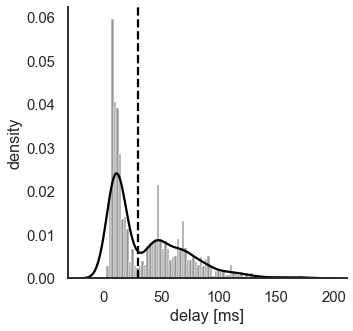

In [3]:
plt.subplots(figsize = (5,5))

ax = sns.distplot(startle_df_3[startle_df_3['genotype']=='pth2$^{+/+}$']['startle'], bins = 80,
                  axlabel = 'delay [ms]' ,
                  color='k', 
                  kde = True
                 )
ax.set(ylabel = 'density')
ax.axvline(30, ls = '--' , color = 'k')
sns.despine()

# in case of distplot being already removed (it is a deprecated function in July 2021), use the snippet below (for the paper, distplot was used):

#ax = sns.displot(data=startle_df_3[startle_df_3['genotype']=='pth2$^{+/+}$'] , 
#                 x="startle" , 
#                 kde=True , 
#                 bins = 80)

In [4]:
ttest_ind(ko_platewise_SLC ,
             wt_platewise_SLC)

Ttest_indResult(statistic=-2.329000076113376, pvalue=0.026129466627341887)

## Figure 2c: Distribution of delay after startle stimulus

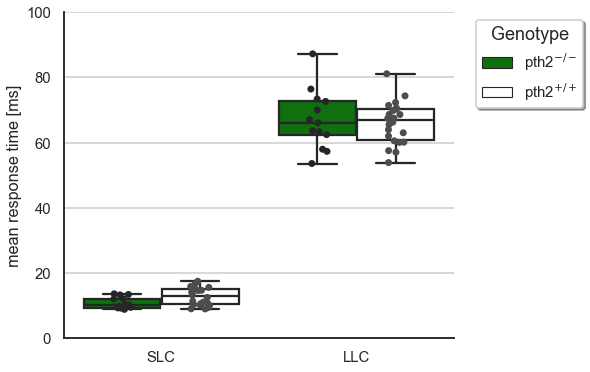

In [5]:
# Initialize the figure 
f, ax = plt.subplots(figsize=(7, 6))
f = sns.boxplot(x="response", y="startle",
            hue="genotype", palette=["g", "w"],
            data=startle_df_2)

sns.stripplot(x="response", y="startle",
            hue="genotype", color=".3",
            data=startle_df_2,dodge = True,
              size=7, linewidth=0)
ax.yaxis.grid(True)
ax.set(ylabel="mean response time [ms]")
ax.set(xlabel = '')
sns.despine(trim=False, left=False)
ax.set(ylim = (0,100))

handles, labels = ax.get_legend_handles_labels()

f.legend(handles[0:2], \
         labels[0:2], \
         fontsize = 15, \
         bbox_to_anchor= (1.35, 1), \
         title="Genotype", \
         title_fontsize = 18, \
         shadow = True, \
         facecolor = 'white');

In [11]:
# compute cohen's D:
print("for SLC, effect strength is " + str(cohend(ko_platewise_SLC, wt_platewise_SLC)))
print("for LLC, effect strength is " + str(cohend(ko_platewise_LLC, wt_platewise_LLC)))

# compute median of wt LLC:
print("mean response time for wt, SLC: " + str(np.median(wt_platewise_SLC)))
print("mean response time for wt, LLC: " + str(np.median(wt_platewise_LLC)))
print("mean response time for ko, SLC: " + str(np.median(ko_platewise_SLC)))
print("mean response time for ko, LLC: " + str(np.median(ko_platewise_LLC)))

for SLC, effect strength is -0.81474275705311
for LLC, effect strength is 0.1333962600461591
mean response time for wt, SLC: 12.897773279352228
mean response time for wt, LLC: 66.84074074074073
mean response time for ko, SLC: 10.203389830508474
mean response time for ko, LLC: 66.07407407407408


## Figure 2d: Responsiveness to startle cues

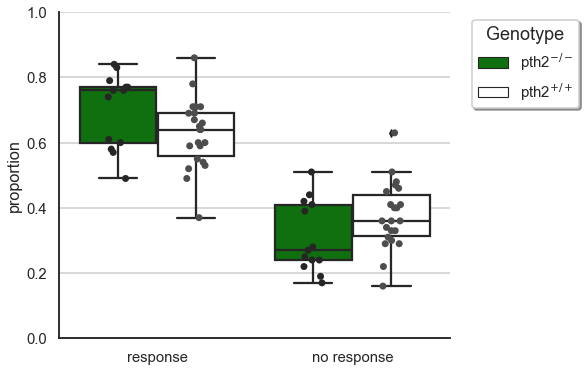

In [12]:
# Initialize the figure 
f, ax = plt.subplots(figsize=(7, 6))
f = sns.boxplot(x="variable", y="value",
            hue="label", palette=["g", "w"],
            data=df_reduced)

sns.stripplot(x="variable", y="value",
            hue="genotype", color=".3",
            data=df_reduced,dodge = True,
              size=7, linewidth=0)
ax.yaxis.grid(True)
ax.set(ylabel="proportion")
ax.set(xlabel = '')
ax.set_xticklabels(['response', 'no response'])
sns.despine(trim=False, left=False)
ax.set(ylim = (0,1))

handles, labels = ax.get_legend_handles_labels()

f.legend(handles[0:2], \
         labels[0:2], \
         fontsize = 15, \
         bbox_to_anchor= (1.35, 1), \
         title="Genotype", \
         title_fontsize = 18, \
         shadow = True, \
         facecolor = 'white');


In [19]:
# compute cohen's D:
print("response effect size is " + str(cohend(df_reduced[df_reduced['genotype']=='ko'][df_reduced[df_reduced['genotype']=='ko']['variable']=='Response']['value'] ,
df_reduced[df_reduced['genotype']=='wt'][df_reduced[df_reduced['genotype']=='wt']['variable']=='Response']['value'])))

# compute central tendencies
print("mean response rate for wildtype is " + str(np.mean(df_reduced[df_reduced['genotype']=='wt'][df_reduced[df_reduced['genotype']=='wt']['variable']=='Response']['value'])))
print("mean response rate for mutant is " + str(np.mean(df_reduced[df_reduced['genotype']=='ko'][df_reduced[df_reduced['genotype']=='ko']['variable']=='Response']['value'])))

response effect size is 0.6801028663520059
mean response rate for wildtype is 0.6268181818181818
mean response rate for mutant is 0.7007692307692307


## Figure 2e: Distribution of SLCs, LLCs, and no-responders

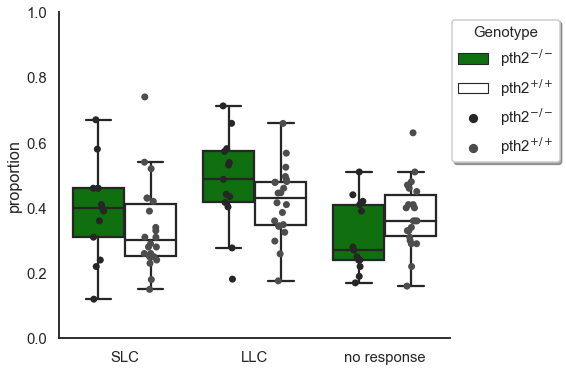

In [20]:
f, ax = plt.subplots(figsize=(7, 6))

f = sns.boxplot(x="variable", y="value",
            hue="label", palette=["g", "w"],
            data=startle_df_melt,
            showfliers = False)

sns.stripplot(x="variable", y="value",
            hue="label", color=".3",
            data=startle_df_melt,dodge = True,
              size=7, linewidth=0)

ax.xaxis.grid(False)
ax.set(ylabel="proportion")
ax.set(xlabel = "")
ax.set_xticklabels(['SLC', 'LLC', 'no response'])
sns.despine(trim=False, left=False)
ax.set(ylim = (0,1))


f.legend(fontsize = 15, \
               bbox_to_anchor= (1.3, 1), \
               title="Genotype", \
               title_fontsize = 15, \
               shadow = True, \
               facecolor = 'white');


In [35]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

features = ['LLC', 'SLC', 'NoR', 'genotype']
new_df = df.loc[:, features]
new_df['genotype'] = [0 if i == "wt" else 1 for i in new_df["genotype"]]

startle_lm = ols('genotype ~ LLC * SLC * NoR ', data=new_df).fit()
table = sm.stats.anova_lm(startle_lm, typ=3)
print(table)

               sum_sq    df         F    PR(>F)
Intercept    0.036343   1.0  0.184832  0.670665
LLC          0.008818   1.0  0.044846  0.833878
SLC          0.176916   1.0  0.899744  0.351264
LLC:SLC      0.848807   1.0  4.316786  0.047375
NoR          0.067894   1.0  0.345289  0.561675
LLC:NoR      0.757178   1.0  3.850788  0.060105
SLC:NoR      1.281805   1.0  6.518890  0.016638
LLC:SLC:NoR  1.366791   1.0  6.951100  0.013719
Residual     5.308994  27.0       NaN       NaN


MannwhitneyuResult(statistic=98.0, pvalue=0.06435545775220129)

In [22]:
############################
# PCA of startle responses #
############################

# 1. Standardize

features = ['LLC', 'SLC', 'NoR']
x = df.loc[:, features].values # Separating out the features
y = df.loc[:,['genotype']].values # Separating out the target
x = StandardScaler().fit_transform(x) # Standardizing the features

# 2. PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

# 3. Join reduced features and target

finalDf = pd.concat([principalDf, df['genotype']], axis = 1)

pca.explained_variance_ratio_



array([0.6125703 , 0.38328129])

In [23]:
###########################
# Fit logistic regression #
###########################

# repeat procedure 1000 times
accuracy = np.repeat(np.nan, 1000)

# 1. define variables
x = principalDf # use principal components from PCA above
y = pd.Series([0 if x == 'ko' else 1 for x in df['genotype']])
    
# 2. balance number of replicates by oversampling
number_of_wt = sum(y)
number_of_ko = len(y)-number_of_wt
idx = np.where(np.array(y) == 0)
add_samples = np.max([number_of_wt, number_of_ko]) - np.min([number_of_wt, number_of_ko])

accuracy_os = np.repeat(np.nan, 1000)
for i in np.arange(0,1000,1):
    # oversample
    rand_idx = random.sample(list(idx[0]), add_samples)
    x2 = x.append(x.iloc[rand_idx])
    y2 = y.append(y.iloc[rand_idx])
    # 3. split into training and test set
    x_train, x_test, y_train, y_test =\
        train_test_split(x2, y2, test_size=0.3, random_state=i) # change random state each time

    # 4. train the model
    model = LogisticRegression(solver='liblinear', random_state=0).fit(x_train, y_train)
    accuracy_os[i] = model.score(x_test,y_test)
    
# logistic regression model for significance tests

# get independent variables
scaler = MinMaxScaler()
features = ['LLC', 'SLC', 'NoR']
x = df.loc[:, features].values
X = scaler.fit_transform(x)

# fit the model with maximum likelihood function
model = sm.Logit(endog=y, exog=X).fit()

print(model.summary())

# get odds ratio
np.exp(model.params)

Optimization terminated successfully.
         Current function value: 0.609582
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   35
Model:                          Logit   Df Residuals:                       32
Method:                           MLE   Df Model:                            2
Date:                Mon, 29 Nov 2021   Pseudo R-squ.:                 0.07599
Time:                        18:58:20   Log-Likelihood:                -21.335
converged:                       True   LL-Null:                       -23.090
Covariance Type:            nonrobust   LLR p-value:                    0.1730
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.7522      1.121     -0.671      0.502      -2.949       1.444
x2            -0.2054      1.

x1     0.471306
x2     0.814296
x3    12.475450
dtype: float64

## Extended Data Figure 2b: Accuracy of logistic regression

0.5725

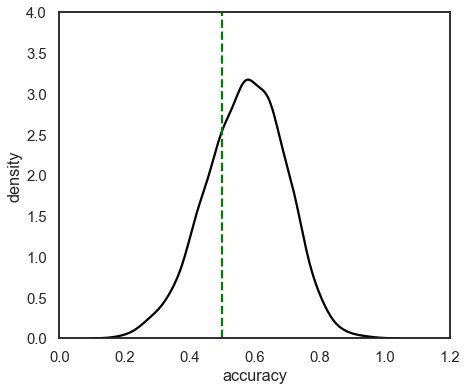

In [24]:
f, ax = plt.subplots(figsize=(7,6))
sns.kdeplot(accuracy_os, bw_adjust = 1.3, color="k")
plt.plot([0.5, 0.5], [0, 4.2], '--g')
ax.set_ylim(0,4)
ax.set_xlim(0,1.2)
ax.set_xlabel('accuracy')
ax.set_ylabel('density')

np.mean(accuracy_os)

## Extended Data Figure 2c: Confusion Matrix
and 
## Extended Data Figure 2d: Decision Boundary

              precision    recall  f1-score   support

           0       0.57      0.62      0.59        13
           1       0.76      0.73      0.74        22

    accuracy                           0.69        35
   macro avg       0.67      0.67      0.67        35
weighted avg       0.69      0.69      0.69        35



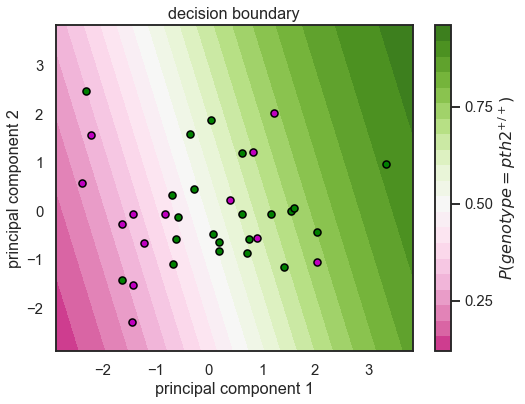

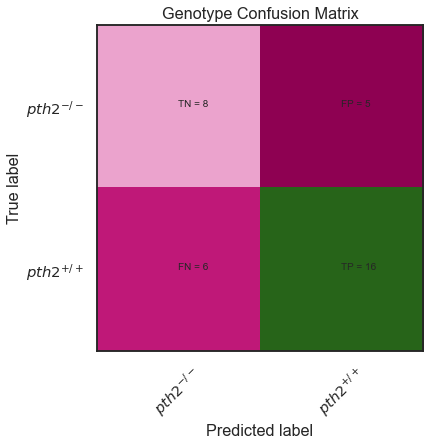

In [25]:
random.seed(12)
x = principalDf # use principal components from PCA above
y = pd.Series([0 if x == 'ko' else 1 for x in df['genotype']])
# train model using the entire dataset (oversampled)
rand_idx = random.sample(list(idx[0]), add_samples)
x2 = x.append(x.iloc[rand_idx])
y2 = y.append(y.iloc[rand_idx])

model = LogisticRegression(solver='liblinear', random_state=0).fit(x2, y2)

# plot decision boundary

xx, yy = np.mgrid[principalDf.iloc[:,0].min()-0.5:principalDf.iloc[:,0].max()+0.5:.01, principalDf.iloc[:,0].min()-0.5:principalDf.iloc[:,0].max()+0.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="PiYG",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(genotype = pth2^{+/+})$")
ax_c.set_ticks([0, .25, .5, .75, 1])


targets = ['ko', 'wt']
colors = ['m', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['genotype'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50,
              edgecolor="black")

ax.set(#aspect="equal",
       #xlim=(-2, 5), ylim=(-5, 5),
       xlabel="principal component 1", ylabel="principal component 2",
        title = "decision boundary")

cm = confusion_matrix(y, model.predict(x))
print(classification_report(y, model.predict(x)))
f, ax = plt.subplots(figsize=(8, 6))
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap="PiYG")#plt.cm.Wistia)
classNames = ['$pth2^{-/-}$','$pth2^{+/+}$']
plt.title('Genotype Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
   